In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Matrix, Function, simplify, exp, hessian, solve, init_printing
import numpy.linalg as lin
import autograd.numpy as np 
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize
import pymc3 as pm
init_printing()

# Logistic Regression - Param Fit and Uncertainty

### Equations

In [2]:
def logodds(x, beta):
    lo = (beta[0] + np.dot(1 * beta[1::], x))
    return lo

def p(logodds):
    return 1 / (1 + np.exp(-1 * logodds))

def logloss(x, y, beta_params):
    lo = logodds(x, beta_params)
    ### If lo = 20+ and y = 0 get -20+; if lo = -20- and y =1 get -20-
    if lo > 20:
        return - lo * (1 - y)
    elif lo < -20:
        return lo * y
    else:
        return (np.log(p(lo)) * y + np.log(1 - p(lo)) * (1 - y))

def negative_log_likelihood(beta_params, x_train, y_train):
    return -1 *np.sum([logloss(xi, yi, beta_params) for xi, yi in zip(x_train, y_train)] )

### Simulate Data

In [3]:
n = 1000
beta_true = np.array([.1, -.5, 2.3])
x_train = np.random.uniform(low = -5, high = 5, size = (n,2))
p_train = [p(logodds(xi, beta = beta_true)) for xi in x_train]
y_train = np.random.binomial(n = 1, p = p_train)
negative_log_likelihood(beta_true, x_train, y_train)

In [4]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit

In [5]:
log_reg = sm.Logit( y_train, sm.tools.tools.add_constant(x_train)).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.143306
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Wed, 22 Mar 2023   Pseudo R-squ.:                  0.7932
Time:                        20:47:00   Log-Likelihood:                -143.31
converged:                       True   LL-Null:                       -692.81
Covariance Type:            nonrobust   LLR p-value:                2.257e-239
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2059      0.153      1.349      0.177      -0.093       0.505
x1            -0.4287      0.

### Parameter Estimates from MLE and Fisher information (inv Hessian at MLE) std error

#### MLE

In [6]:
b0 = [0,0,0]
jacobian_ = jacobian(negative_log_likelihood)
hessian_ = hessian(negative_log_likelihood)

result = minimize(negative_log_likelihood, b0, args=(x_train, y_train), jac = jacobian_, method='Nelder-Mead')
print(result.x)

/home/christine/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


[ 0.20587073 -0.42872508  2.25443689]


#### Std Error

In [7]:
hessinv = np.linalg.inv(hessian_(result.x, x_train, y_train))
print(np.sqrt(np.diag(hessinv)))

[0.15268013 0.06263358 0.18691614]


In [8]:
beta0_plt = result.x[0]
beta1_plt = np.linspace(-2, 3, 50)
beta2_plt = np.linspace(0, 5, 50)
like_plt = np.zeros((len(beta1_plt), len(beta2_plt)))
for i,b1 in enumerate(beta1_plt):
    for j,b2 in enumerate(beta2_plt):
        like_plt[i,j] = negative_log_likelihood([beta0_plt, b1, b2], x_train, y_train)

<IPython.core.display.Javascript object>


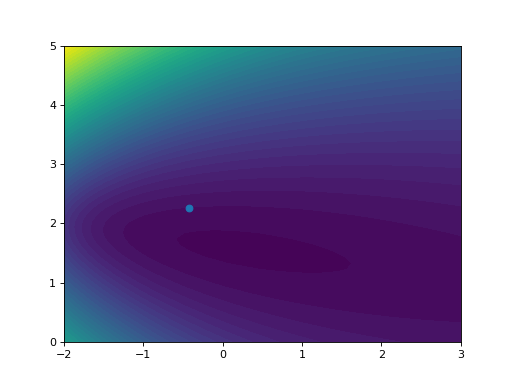

In [9]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.contourf(beta1_plt, beta2_plt,like_plt, levels = 50)
ax.scatter(result.x[1],result.x[2])

### 1/sqrt(n) MLE estimate stddev dependence from sim


In [335]:
n_obs = [200,500,1000,2000]
beta_true = np.array([.1, -.5, 2.3])
b0 = [0,0,0]
hessian_ = hessian(negative_log_likelihood)
fits = {}
for n in n_obs:
    print(n)
    fits[n] = {'mle':[], 'std_err' : []}
    for i in range(150):
        x_train = np.random.uniform(low = -5, high = 5, size = (n,2))
        p_train = [p(logodds(xi, beta = beta_true)) for xi in x_train]
        y_train = np.random.binomial(n = 1, p = p_train)
        result = minimize(negative_log_likelihood, b0, args=(x_train, y_train), jac = jacobian_, method='Nelder-Mead')
        fits[n]['mle'].append(result.x)
        hessinv = np.linalg.inv(hessian_(result.x, x_train, y_train))
        fits[n]['std_err'].append(np.sqrt(np.diag(hessinv)))

200
500
1000
2000


In [12]:
import pickle
#with open('frequentist_data.pkl', 'wb') as f:
#    pickle.dump(fits, f)
fits = pickle.load(open('frequentist_data.pkl','rb'))

<IPython.core.display.Javascript object>


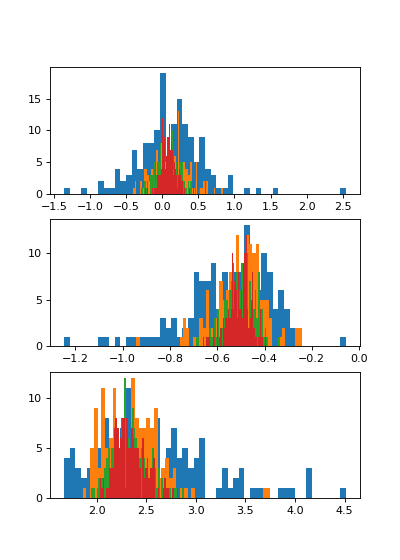

In [36]:
n_obs = [200,500,1000,2000]
fig, ax = plt.subplots((3), figsize = (5,7))
sim_stds = {'b0' : [], 'b1' : [], 'b2' : []}
hess_stds = {'b0' : [], 'b1' : [], 'b2' : []}
for n in n_obs:   
    fs = []
    for b in range(3):
        ax[b].hist(np.array(fits[n]['mle'])[:,b], bins = 50)
        sim_stds[f'b{b}'].append(np.std(np.array(fits[n]['mle'])[:,b]))
        hess_stds[f'b{b}'].append((np.mean(np.array(fits[n]['std_err'])[:,b])))


<IPython.core.display.Javascript object>


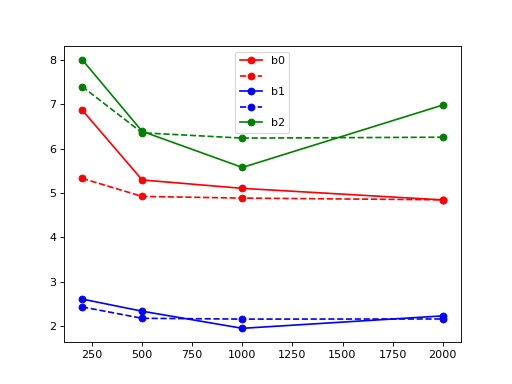

In [45]:
fig,ax = plt.subplots()
color = ['red','blue','green']
for b in range(3):
    ax.plot(n_obs, sim_stds[f'b{b}'] * np.sqrt(n_obs), color = color[b], marker = 'o')
    ax.plot(n_obs, hess_stds[f'b{b}'] * np.sqrt(n_obs), color = color[b], linestyle = '--', marker = 'o')
ax.legend(['b0','', 'b1','', 'b2'])

### Bayesian estimation

p(Beta | y) ~ p(y | Beta) * p(Beta)

In [47]:
def bayesian_log_regression(x_train, y_train):
    with pm.Model() as log_regression_model:
        betas = []
        # priors
        for n in range(3):
            betas.append(pm.Normal(f"β{n}", mu=0, sigma=5))
        # logistic regression model
        μ = betas[0] + betas[1] * x_train[:,0] + betas[2] * x_train[:,1]
        p = pm.Deterministic("p", pm.math.invlogit(μ))
        # likelihood
        pm.Bernoulli("y", p=p, observed=y_train)
    return log_regression_model

def get_95_hdi(arr):
    return np.quantile(arr, .975) - np.quantile(arr, .025)

fits_b = {}
for n in n_obs:
    print(n)
    fits_b[n] = {'post_mean':[], 'post_95_hdi' : []}
    x_train = np.random.uniform(low = -5, high = 5, size = (n,2))
    p_train = [p(logodds(xi, beta = beta_true)) for xi in x_train]
    y_train = np.random.binomial(n = 1, p = p_train)
    log_regression_model = bayesian_log_regression(x_train, y_train)
    with log_regression_model:
        trace = pm.sample(
            4000, tune=4000, target_accept=0.95,);
        fits_b[n]['post_mean'].append([np.mean(trace[f'β{j}']) for j in range(3)])
        fits_b[n]['post_95_hdi'].append([get_95_hdi(trace[f'β{j}']) for j in range(3)])

200


/home/christine/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β2, β1, β0]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 14 seconds.


500


/home/christine/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β2, β1, β0]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 15 seconds.


1000


/home/christine/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β2, β1, β0]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 18 seconds.


2000


/home/christine/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β2, β1, β0]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 26 seconds.


<IPython.core.display.Javascript object>


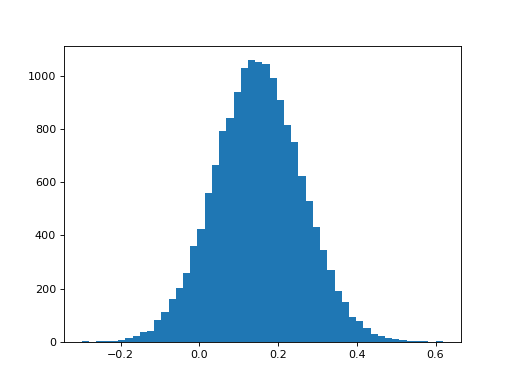

0.14964070634604873
-0.5605062194737698
2.3000867514361616


In [48]:
fig, ax = plt.subplots();
ax.hist(trace['β0'], bins = 50);
for n in range(3):
    print(np.mean(trace[f'β{n}']))

In [49]:
fits_b

{200: {'post_mean': [[-0.09705537390463909,
    -0.7401920988097984,
    3.0591437330660374]],
  'post_95_hdi': [[1.8270207634289615,
    0.8490214437184198,
    2.475437985500644]]},
 500: {'post_mean': [[0.18296123165817393,
    -0.46397663999209254,
    2.3537927042421325]],
  'post_95_hdi': [[0.8948826796680569, 0.379190608973662, 1.119050353439494]]},
 1000: {'post_mean': [[0.03677446040503403,
    -0.3818557339176898,
    1.9529353463784518]],
  'post_95_hdi': [[0.5541281728564387,
    0.22330282482555847,
    0.5957674446690295]]},
 2000: {'post_mean': [[0.14964070634604873,
    -0.5605062194737698,
    2.3000867514361616]],
  'post_95_hdi': [[0.43724216616665285,
    0.19807294763948435,
    0.5421757598502972]]}}